In [3]:
!pip install torchinfo opendatasets wandb munch transformers --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [4]:
import random
import cv2
import numpy as np
import pandas as pd
import os
import time
import copy
import opendatasets as od
import torch
import torch.nn as nn
import torchvision

from PIL import Image
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from torch import optim
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
from scipy.io import loadmat
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
# model_checkpoint = 'google/vit-base-patch16-224-in21k'

In [5]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/eduardo4jesus/stanford-cars-dataset")

100%|██████████| 1.82G/1.82G [01:53<00:00, 17.3MB/s]


In [6]:
NUMWORKERS = os.cpu_count()
IMG_SIZE = 480
IMAGE_CHANNELS = 3
NUM_CLASSES = 196
# IMAGENET_MEAN = [0.485, 0.456, 0.406]
# IMAGENET_STD = [0.229, 0.224, 0.225]
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]
SCALE = 1.1
BATCHSIZE=8

#DIR CONFIGS
DATA_PATH = Path('/content/stanford-cars-dataset')
META_PATH = Path(os.path.join(DATA_PATH,"car_devkit","devkit"))
CARS_TRAIN_PATH = Path(os.path.join(DATA_PATH,"cars_train","cars_train"))
CARS_TEST_PATH = Path(os.path.join(DATA_PATH,"cars_test","cars_test"))

# PRETRAINED = 'google/vit-large-patch16-224-in21k'
# HIDDEN_STATE = 1024
# PRETRAINED = 'google/vit-base-patch16-224'
# HIDDEN_STATE = 768

In [8]:
def set_seeds(TORCH_SEED: int) -> None:
    """
    Sets the manual SEED
    """
    random.seed(TORCH_SEED)
    np.random.seed(TORCH_SEED)
    torch.manual_seed(TORCH_SEED)
    torch.cuda.manual_seed_all(TORCH_SEED)
    os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> str:
    """
    Returns the default device available
    """
    return "cuda" if torch.cuda.is_available() else "cpu"

def denormalize(images, means=MEAN, stds=STD,device=get_device()):
    """
    Returns the denormalized image.
    """
    means = torch.tensor(means).reshape(1, 3, 1, 1).to(device)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1).to(device)
    return (images * stds + means)

Data

The data is analyzed in this notebook

In [9]:
class DefaultDataset(Dataset):
    def __init__(self, data_df,
                 transform = None,
                 is_test: bool = False):
        self.data_df = data_df
        self.is_test = is_test
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        # Get image details
        img_details = self.data_df.iloc[idx]

        img_path = img_details["file_path"]
        # image = cv2.imread(img_path)
        # img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.open(img_path)
        img = image.convert("RGB")

        if self.transform:
            img = self.transform(img).to(torch.float)
        else:
            transform = transforms.ToTensor()
            img = transform(img).to(torch.float)

        if self.is_test:
            return img
        else:
            class_label = torch.tensor(img_details["class_idx"], dtype=torch.long)
            return (img, class_label)

def get_transforms(type):
    if type == 'train':
        train_transform = transforms.Compose([
            transforms.Resize((int(IMG_SIZE * SCALE),
                               int(IMG_SIZE * SCALE))),
            transforms.RandomResizedCrop(IMG_SIZE),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN,
                                 std=STD)
        ])
        return train_transform

    elif type == 'test':
        val_test_transform = transforms.Compose([
            transforms.Resize(int(IMG_SIZE * SCALE)),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN,
                                 std=STD)
        ])
        return val_test_transform

def create_train_df(labels):
    cars_train_annos = loadmat(Path(META_PATH) / 'cars_train_annos.mat')
    train_data = [[val.flat[0] for val in line] for line in cars_train_annos["annotations"][0]]
    columns = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class_idx", "fname"]
    train_df = pd.DataFrame(train_data, columns=columns)
    train_df["class_idx"] = train_df["class_idx"] - 1
    train_df = train_df.merge(labels, left_on='class_idx', right_index=True)
    func = lambda x: os.path.join(CARS_TRAIN_PATH, x)
    train_df["file_path"] = train_df["fname"].apply(func)
    return train_df

def create_test_df():
    cars_test_annos = loadmat(Path(META_PATH) / 'cars_test_annos.mat')
    test_data = [[val.flat[0] for val in line] for line in cars_test_annos["annotations"][0]]
    columns = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "fname"]
    test_df = pd.DataFrame(test_data, columns=columns)
    func = lambda x: os.path.join(CARS_TEST_PATH, x)
    test_df["file_path"] = test_df["fname"].apply(func)
    return test_df

def create_labels():
    cars_meta = loadmat(Path(META_PATH) / 'cars_meta.mat')
    labels = [car for car in cars_meta["class_names"][0]]
    labels = pd.DataFrame(labels, columns=["class_labels"])
    labels['class_labels'] = labels['class_labels'].str.replace(' ', '_')
    return labels

def get_data():
    labels = create_labels()
    train_df = create_train_df(labels)
    test_df = create_test_df()
    train_df, val_df = train_test_split(
        train_df,
        train_size=0.8,
        random_state=42,
        stratify=train_df["class_idx"]
    )
    return train_df, val_df, test_df

def create_dataloaders(train_df: pd.DataFrame,
                       val_df: pd.DataFrame,
                       test_df: pd.DataFrame):
    train_transform = get_transforms("train")
    val_test_transform = get_transforms("test")

    # Create the training, validation, and test datasets using the appropriate transforms
    train_dataset = DefaultDataset(data_df=train_df, transform=train_transform, is_test=False)
    val_dataset = DefaultDataset(data_df=val_df, transform=val_test_transform, is_test=False)
    test_dataset = DefaultDataset(data_df=test_df, transform=val_test_transform, is_test=True)

    # Create the training, validation, and test dataloaders using the appropriate datasets and batch size
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=BATCHSIZE,
        shuffle=True,
        num_workers=NUMWORKERS,
        pin_memory=True
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=BATCHSIZE,
        shuffle=False,  # Do not shuffle the data
        num_workers=NUMWORKERS,
        pin_memory=True
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=BATCHSIZE * 2,
        shuffle=False,  # Do not shuffle the data
        num_workers=NUMWORKERS,
        pin_memory=True
    )

    return train_dataloader, val_dataloader, test_dataloader

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
train_df, val_df, test_df = get_data()
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(train_df, val_df, test_df)

Model

In [12]:
# class ViT(nn.Module):
#     def __init__(self, config=ViTConfig(),
#                num_classes=NUM_CLASSES,
#                model_checkpoint=PRETRAINED):

#         super(ViT, self).__init__()

#         self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
#         for param in self.vit.parameters():
#             param.requires_grad = False
#         self.classifier =  nn.Sequential(
#             nn.Linear(HIDDEN_STATE, out_features=num_classes))
#         #     nn.ReLU(inplace=True),
#         #     nn.Dropout(p=0.1),
#         #     nn.Linear(in_features=512, out_features=num_classes)
#         # )

#         self.initialize_weights()

#     def forward(self, x):
#         x = self.vit(x)['last_hidden_state']
#         # Use the embedding of [CLS] token
#         output = self.classifier(x[:, 0, :])
#         return output

#     def initialize_weights(self):
#         # Initialize the classifier weights using Xavier uniform distribution
#         for module in self.classifier.modules():
#             if isinstance(module, nn.Linear):
#                 nn.init.xavier_uniform_(module.weight)
#                 if module.bias is not None:
#                     nn.init.constant_(module.bias, 0)

class VehicleImageClassfier(nn.Module):
    def __init__(
        self,
        image_channels: int = IMAGE_CHANNELS,
        num_classes: int = NUM_CLASSES,
        num_layers: int = 50
    ):

        super(VehicleImageClassfier,self).__init__()

        self.image_channels = image_channels
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.classification_model = self.get_backbone()

        # self.classification_model.fc = nn.Sequential(
        #     #nn.Linear(in_features=1* 1* self.in_features, out_features=1 * 1 * self.in_features//2),
        #     nn.Linear(in_features=1* 1* self.in_features, out_features=num_classes)
        #     # nn.ReLU(),
        #     # # nn.Linear(in_features=1 * 1 * self.in_features//2,out_features=1 * 1 * self.in_features),
        #     # nn.Dropout(p=0.3),#inplace=True),
        #     # nn.Linear(in_features=512, out_features=num_classes)
        #     #nn.Linear(in_features=1 * 1 * self.in_features, out_features=num_classes)
        # )
        self.classification_model.classifier = nn.Sequential(
            nn.Dropout(p=0.3,inplace=True),
            nn.Linear(in_features=1280, out_features=num_classes))

    def forward(self,x):
        y_classification = self.classification_model(x)
        return y_classification

    def get_backbone(self):
        weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
        pretrained_model = torchvision.models.efficientnet_v2_s(weights=weights)
        # self.in_features = pretrained_model.classifier.in_features

#         for param in pretrained_model.parameters():
#             param.requires_grad = False
        return pretrained_model

    def initialize_weights(self):
        # Initialize the classifier weights using Xavier uniform distribution
        for module in self.classification_model.classifier.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

In [13]:
model= VehicleImageClassfier()

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 54.6MB/s]


In [14]:
from torchinfo import summary

summary(model,
        input_size=(8, 3, IMG_SIZE, IMG_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape     Output Shape    Param #         Trainable
VehicleImageClassfier (VehicleImageClassfier)                     [8, 3, 480, 480] [8, 196]        --              True
├─EfficientNet (classification_model)                             [8, 3, 480, 480] [8, 196]        --              True
│    └─Sequential (features)                                      [8, 3, 480, 480] [8, 1280, 15, 15] --              True
│    │    └─Conv2dNormActivation (0)                              [8, 3, 480, 480] [8, 24, 240, 240] 696             True
│    │    └─Sequential (1)                                        [8, 24, 240, 240] [8, 24, 240, 240] 10,464          True
│    │    └─Sequential (2)                                        [8, 24, 240, 240] [8, 48, 120, 120] 303,552         True
│    │    └─Sequential (3)                                        [8, 48, 120, 120] [8, 64, 60, 60] 589,184         True
│    │    └─Sequential (4

Model Performance before training

In [15]:
def evaluate_batch(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall

In [16]:
def evaluate(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              criterion: torch.nn.Module):
    model.eval()
    device = get_device()
    test_loss, test_acc, test_precision, test_recall = 0, 0, 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = criterion(test_pred_logits, y)
            test_loss += loss.item()

            #Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            batch_acc,batch_precision,batch_recall = evaluate_batch(y,test_pred_labels)

            test_acc += batch_acc
            test_precision += batch_precision
            test_recall += batch_recall

    # Calculate average metrics per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    test_precision = test_precision / len(dataloader)
    test_recall = test_recall / len(dataloader)

    return test_loss, test_acc, test_precision, test_recall

In [17]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, test_precision, test_recall = evaluate(model,val_dataloader,criterion)

test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f'''                         Metrics before training
 val_loss: {test_loss:.4f} | val_acc: {test_acc:.4f} | val_f1_score: {test_f1_score:.4f} ''')

                         Metrics before training
 val_loss: 5.2881 | val_acc: 0.0123 | val_f1_score: 0.0063 


predict a single image before training

In [18]:
labels = create_labels()

def predict(img_path,model):
    device = get_device()
    transform = get_transforms('test')
    img = Image.open(img_path)
    img = transform(img)
    output = model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return labels.iloc[prediction]

In [19]:
sample = val_df.sample()
sample

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_idx,fname,class_labels,file_path
1440,126,118,768,538,147,01441.jpg,Jeep_Grand_Cherokee_SUV_2012,/content/stanford-cars-dataset/cars_train/cars...


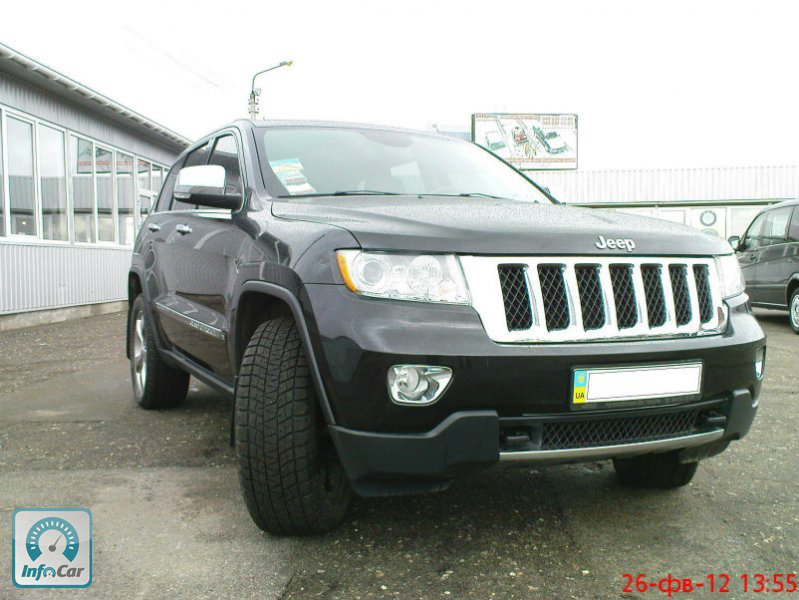

In [20]:
img = Image.open(sample['file_path'].item())
img

In [21]:
labels.iloc[sample['class_idx'].item()]

class_labels    Jeep_Grand_Cherokee_SUV_2012
Name: 147, dtype: object

prediction

In [22]:
predict(sample['file_path'].item(),model)

class_labels    Mercedes-Benz_C-Class_Sedan_2012
Name: 161, dtype: object

Model Training

In [23]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
def save_model(model_save_path, model,optimizer,epoch,avg_metrics):
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(
            {
                'epoch': epoch,
                'avg_metrics': avg_metrics,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            },
            f=model_save_path
        )

In [25]:
def train_model(model,train_dataloader,test_dataloader,config):
    device = get_device()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(),lr=config.learning_rate,weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    wandb.init(project=config.project,name=config.experiment_name,config=config)

    for epoch in tqdm(range(config.start_iter,config.epochs)):

        model.train()
        train_loss, train_acc, train_precision, train_recall = 0, 0, 0, 0
        for  (X, y) in (train_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()

            if config.grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), config.grad_clip)
            optimizer.step()

            with torch.no_grad():
                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                batch_acc,batch_precision,batch_recall = evaluate_batch(y,y_pred_class)

                train_acc += batch_acc
                train_precision += batch_precision
                train_recall += batch_recall

        # calculate avg metrics per batch
        avg_metrics = OrderedDict()
        avg_metrics['lr'] = optimizer.param_groups[0]['lr']
        avg_metrics['train_loss'] = train_loss / len(train_dataloader)
        avg_metrics['train_acc'] = train_acc / len(train_dataloader)
        avg_metrics['train_precision'] = train_precision/ len(train_dataloader)
        avg_metrics['train_recall'] = train_recall/ len(train_dataloader)
        avg_metrics['train_f1'] = (2 * (train_precision * train_recall) / (train_precision + train_recall)) / len(train_dataloader)

        test_loss, test_acc, test_precision, test_recall = evaluate(model,test_dataloader,criterion)
        avg_metrics['val_loss'] = test_loss
        avg_metrics['val_acc'] = test_acc
        avg_metrics['val_precision'] = test_precision
        avg_metrics['val_recall'] = test_recall
        avg_metrics['val_f1'] = 2 * (test_precision * test_recall) / (test_precision + test_recall)

        scheduler.step()

        wandb.log(avg_metrics, step=epoch+1)
        print(f"Epoch : {epoch+1}")
        print(f"Train Loss : {avg_metrics['train_loss']: .4f} | Train Acc : {avg_metrics['train_acc']: .4f} | Train F1 : {avg_metrics['train_f1']: .4f} ")
        print(f"Val Loss   : {avg_metrics['val_loss']: .4f}   | Val Acc : {avg_metrics['val_acc']: .4f}     | Val F1   : {avg_metrics['val_f1']: .4f}")

        if (epoch+1) % config.checkpoint_period == 0:
            os.makedirs(config.models_dir, exist_ok=True)
            model_save_path  = os.path.join(config.models_dir, f'model_chkpt_{epoch+1}_acc_{avg_metrics["val_acc"]: .3f}.pth')
            # save_model(model_save_path, model,optimizer,epoch+1,avg_metrics)
        if avg_metrics['val_acc']  > best_acc and avg_metrics['val_acc'] > 0.4:
            best_acc = avg_metrics['val_acc']
            best_model_wts = copy.deepcopy(model.state_dict())
            os.makedirs(config.models_dir, exist_ok=True)
            model_save_path  = os.path.join(config.models_dir, f'{config.experiment_name}_best_model.pth')
            save_model(model_save_path, model,optimizer,epoch+1,avg_metrics)

    wandb.finish()
    print()
    print(f"Best Val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    return model

In [27]:
from munch import Munch
config = dict()
config.update({
    "project":"kaggle_vit",
    "experiment_name":"Efficientnet_V2_S_model_Adam_normal_head_bs_8",
    "models_dir": "/content/drive/MyDrive/vit/models",
    "history_dir": "history",
    "start_iter": 0,
    "epochs": 15,
    "checkpoint_period": 3,
    "grad_clip": 1.0,
    "metric": "val_f1",
    "optimizer": "Adam",
    "learning_rate": 0.0001,
    'weight_decay': 0.00001,
    "step_size" : 2,
    "gamma": 0.97,
    "metric_threshold":0.5

})
config = Munch(config)

In [ ]:
set_seeds(42)
model = VehicleImageClassfier().to(get_device())
trained_model = train_model(model,train_dataloader,val_dataloader,config)

wandb: Currently logged in as: vasanthsai26. Use `wandb login --relogin` to force relogin


  7%|▋         | 1/15 [06:11<1:26:41, 371.54s/it]

Epoch : 1
Train Loss :  4.8630 | Train Acc :  0.0495 | Train F1 :  0.0280 
Val Loss   :  3.6419   | Val Acc :  0.2132     | Val F1   :  0.1308
Epoch : 2
Train Loss :  3.4184 | Train Acc :  0.2561 | Train F1 :  0.1594 
Val Loss   :  1.9431   | Val Acc :  0.5010     | Val F1   :  0.3560
[INFO] Saving model to: /content/drive/MyDrive/vit/models/Efficientnet_V2_S_model_Adam_normal_head_bs_8_best_model.pth


 13%|█▎        | 2/15 [12:24<1:20:38, 372.16s/it]

Epoch : 3
Train Loss :  2.3587 | Train Acc :  0.4693 | Train F1 :  0.3292 
Val Loss   :  1.1842   | Val Acc :  0.6751     | Val F1   :  0.5371
[INFO] Saving model to: /content/drive/MyDrive/vit/models/Efficientnet_V2_S_model_Adam_normal_head_bs_8_best_model.pth


 20%|██        | 3/15 [18:49<1:15:38, 378.23s/it]

Epoch : 4
Train Loss :  1.7009 | Train Acc :  0.6181 | Train F1 :  0.4724 
Val Loss   :  0.8429   | Val Acc :  0.7662     | Val F1   :  0.6494
[INFO] Saving model to: /content/drive/MyDrive/vit/models/Efficientnet_V2_S_model_Adam_normal_head_bs_8_best_model.pth


 27%|██▋       | 4/15 [25:13<1:09:46, 380.60s/it]

Epoch : 5
Train Loss :  1.3307 | Train Acc :  0.6975 | Train F1 :  0.5615 
Val Loss   :  0.6227   | Val Acc :  0.8201     | Val F1   :  0.7212
[INFO] Saving model to: /content/drive/MyDrive/vit/models/Efficientnet_V2_S_model_Adam_normal_head_bs_8_best_model.pth


 33%|███▎      | 5/15 [31:30<1:03:11, 379.16s/it]

Epoch : 6
Train Loss :  1.1090 | Train Acc :  0.7428 | Train F1 :  0.6168 
Val Loss   :  0.5692   | Val Acc :  0.8219     | Val F1   :  0.7234
[INFO] Saving model to: /content/drive/MyDrive/vit/models/Efficientnet_V2_S_model_Adam_normal_head_bs_8_best_model.pth


 40%|████      | 6/15 [37:45<56:39, 377.70s/it]  

Epoch : 7
Train Loss :  0.9605 | Train Acc :  0.7759 | Train F1 :  0.6590 
Val Loss   :  0.5325   | Val Acc :  0.8412     | Val F1   :  0.7496
[INFO] Saving model to: /content/drive/MyDrive/vit/models/Efficientnet_V2_S_model_Adam_normal_head_bs_8_best_model.pth


 47%|████▋     | 7/15 [44:00<50:13, 376.75s/it]

Epoch : 8
Train Loss :  0.8273 | Train Acc :  0.8072 | Train F1 :  0.7006 
Val Loss   :  0.4716   | Val Acc :  0.8605     | Val F1   :  0.7776
[INFO] Saving model to: /content/drive/MyDrive/vit/models/Efficientnet_V2_S_model_Adam_normal_head_bs_8_best_model.pth


 60%|██████    | 9/15 [56:30<37:34, 375.70s/it]

Epoch : 9
Train Loss :  0.7782 | Train Acc :  0.8205 | Train F1 :  0.7188 
Val Loss   :  0.4578   | Val Acc :  0.8571     | Val F1   :  0.7729


In [ ]:
def load_checkpoint(checkpoint_path,model,optimizer):

    checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))

    model_state_dict = checkpoint['model_state_dict']
    optimizer_state_dict = checkpoint['optimizer_state_dict']
    model.load_state_dict(model_state_dict)
    optimizer.load_state_dict(optimizer_state_dict)
    epoch = checkpoint["epoch"]
    avg_metrics = checkpoint["avg_metrics"]

    return model,optimizer,epoch,avg_metrics

In [ ]:
model= ViT().to(get_device())
optimizer = optim.Adam(model.parameters(),lr=0.001)
model,optimizer,epoch = load_checkpoint("/content/drive/MyDrive/vit/models/model_best_acc.pth",model,optimizer)

Some weights of the model checkpoint at google/vit-large-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
labels = create_labels()
class_labels_dict = labels['class_labels'].to_dict()

In [ ]:
class_labels_dict

{0: 'AM_General_Hummer_SUV_2000',
 1: 'Acura_RL_Sedan_2012',
 2: 'Acura_TL_Sedan_2012',
 3: 'Acura_TL_Type-S_2008',
 4: 'Acura_TSX_Sedan_2012',
 5: 'Acura_Integra_Type_R_2001',
 6: 'Acura_ZDX_Hatchback_2012',
 7: 'Aston_Martin_V8_Vantage_Convertible_2012',
 8: 'Aston_Martin_V8_Vantage_Coupe_2012',
 9: 'Aston_Martin_Virage_Convertible_2012',
 10: 'Aston_Martin_Virage_Coupe_2012',
 11: 'Audi_RS_4_Convertible_2008',
 12: 'Audi_A5_Coupe_2012',
 13: 'Audi_TTS_Coupe_2012',
 14: 'Audi_R8_Coupe_2012',
 15: 'Audi_V8_Sedan_1994',
 16: 'Audi_100_Sedan_1994',
 17: 'Audi_100_Wagon_1994',
 18: 'Audi_TT_Hatchback_2011',
 19: 'Audi_S6_Sedan_2011',
 20: 'Audi_S5_Convertible_2012',
 21: 'Audi_S5_Coupe_2012',
 22: 'Audi_S4_Sedan_2012',
 23: 'Audi_S4_Sedan_2007',
 24: 'Audi_TT_RS_Coupe_2012',
 25: 'BMW_ActiveHybrid_5_Sedan_2012',
 26: 'BMW_1_Series_Convertible_2012',
 27: 'BMW_1_Series_Coupe_2012',
 28: 'BMW_3_Series_Sedan_2012',
 29: 'BMW_3_Series_Wagon_2012',
 30: 'BMW_6_Series_Convertible_2007',
 31: '

In [ ]:
def evaluate_model(model, val_loader, class_labels):
    model.eval()
    device = get_device()
    total_samples = 0
    correct_predictions = 0

    class_correct = torch.zeros(len(class_labels))
    class_total = torch.zeros(len(class_labels))

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i]
                prediction = predicted[i]
                class_correct[label] += (prediction == label).item()
                class_total[label] += 1

    print('Correctly predicted classes:')
    for i in range(len(class_labels)):
        class_name = class_labels[i]
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'{class_name}: {accuracy:.2f}%')

    print('\nIncorrectly predicted classes:')
    for i in range(len(class_labels)):
        class_name = class_labels[i]
        incorrect_samples = class_total[i] - class_correct[i]
        accuracy = 100 * incorrect_samples / class_total[i]
        print(f'{class_name}: {accuracy:.2f}%')

    print('\nTotal samples:')
    print(f'Total: {total_samples}')
    accuracy = 100 * correct_predictions / total_samples
    print(f'Accuracy: {accuracy:.2f}%')

In [ ]:
evaluate_model(model, val_dataloader, class_labels_dict)

Correctly predicted classes:
AM_General_Hummer_SUV_2000: 88.89%
Acura_RL_Sedan_2012: 16.67%
Acura_TL_Sedan_2012: 66.67%
Acura_TL_Type-S_2008: 12.50%
Acura_TSX_Sedan_2012: 25.00%
Acura_Integra_Type_R_2001: 77.78%
Acura_ZDX_Hatchback_2012: 37.50%
Aston_Martin_V8_Vantage_Convertible_2012: 33.33%
Aston_Martin_V8_Vantage_Coupe_2012: 0.00%
Aston_Martin_Virage_Convertible_2012: 16.67%
Aston_Martin_Virage_Coupe_2012: 75.00%
Audi_RS_4_Convertible_2008: 85.71%
Audi_A5_Coupe_2012: 37.50%
Audi_TTS_Coupe_2012: 11.11%
Audi_R8_Coupe_2012: 11.11%
Audi_V8_Sedan_1994: 55.56%
Audi_100_Sedan_1994: 12.50%
Audi_100_Wagon_1994: 55.56%
Audi_TT_Hatchback_2011: 25.00%
Audi_S6_Sedan_2011: 33.33%
Audi_S5_Convertible_2012: 50.00%
Audi_S5_Coupe_2012: 44.44%
Audi_S4_Sedan_2012: 25.00%
Audi_S4_Sedan_2007: 0.00%
Audi_TT_RS_Coupe_2012: 75.00%
BMW_ActiveHybrid_5_Sedan_2012: 71.43%
BMW_1_Series_Convertible_2012: 14.29%
BMW_1_Series_Coupe_2012: 50.00%
BMW_3_Series_Sedan_2012: 11.11%
BMW_3_Series_Wagon_2012: 62.50%
BMW_6_S

In [ ]:
def evaluate(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              criterion: torch.nn.Module):
    model.eval()
    device = get_device()
    test_loss, test_acc, test_precision, test_recall = 0, 0, 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = criterion(test_pred_logits, y)
            test_loss += loss.item()

            #Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            batch_acc,batch_precision,batch_recall = evaluate_batch(y,test_pred_labels)

            test_acc += batch_acc
            test_precision += batch_precision
            test_recall += batch_recall

    # Calculate average metrics per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    test_precision = test_precision / len(dataloader)
    test_recall = test_recall / len(dataloader)

    return test_loss, test_acc, test_precision, test_recall

def train_model(model,train_dataloader,test_dataloader,config):
    device = get_device()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(),lr=config.learning_rate,weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_metric = 0.0

    wandb.init(project=config.project,name=config.experiment_name,config=config)

    for epoch in tqdm(range(config.start_iter,config.epochs)):

        model.train()
        train_loss, train_acc, train_precision, train_recall = 0, 0, 0, 0
        for  (X, y) in (train_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()

            if config.grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), config.grad_clip)
            optimizer.step()

            with torch.no_grad():
                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                batch_acc,batch_precision,batch_recall = evaluate_batch(y,y_pred_class)

                train_acc += batch_acc
                train_precision += batch_precision
                train_recall += batch_recall

        # calculate avg metrics per batch
        avg_metrics = OrderedDict()
        avg_metrics['lr'] = optimizer.param_groups[0]['lr']
        avg_metrics['train_loss'] = train_loss / len(train_dataloader)
        avg_metrics['train_acc'] = train_acc / len(train_dataloader)
        avg_metrics['train_precision'] = train_precision/ len(train_dataloader)
        avg_metrics['train_recall'] = train_recall/ len(train_dataloader)
        avg_metrics['train_f1'] = (2 * (train_precision * train_recall) / (train_precision + train_recall)) / len(train_dataloader)

        test_loss, test_acc, test_precision, test_recall = evaluate(model,test_dataloader,criterion)
        avg_metrics['val_loss'] = test_loss
        avg_metrics['val_acc'] = test_acc
        avg_metrics['val_precision'] = test_precision
        avg_metrics['val_recall'] = test_recall
        avg_metrics['val_f1'] = 2 * (test_precision * test_recall) / (test_precision + test_recall)

        scheduler.step()

        wandb.log(avg_metrics, step=epoch+1)
        print(f"Epoch : {epoch+1}")
        print(f"Train Loss : {avg_metrics['train_loss']: .4f} | Train Acc : {avg_metrics['train_acc']: .4f} | Train F1 : {avg_metrics['train_f1']: .4f} ")
        print(f"Val Loss   : {avg_metrics['val_loss']: .4f}   | Val Acc : {avg_metrics['val_acc']: .4f}     | Val F1   : {avg_metrics['val_f1']: .4f}")

        if (epoch+1) % config.checkpoint_period == 0:
            os.makedirs(config.models_dir, exist_ok=True)
            model_save_path  = os.path.join(config.models_dir, f'model_chkpt_{epoch+1}_acc_{avg_metrics["val_acc"]: .3f}.pth')
            #save_model(model_save_path, model,optimizer,epoch)
        if avg_metrics[config.metric]  > best_metric and avg_metrics[config.metric] > config.metric_threshold:
            best_acc = avg_metrics[config.metric]
            best_model_wts = copy.deepcopy(model.state_dict())
            os.makedirs(config.models_dir, exist_ok=True)
            model_save_path  = os.path.join(config.models_dir, f'{config.experiment_name}_best_model.pth')
            save_model(model_save_path, model,optimizer,epoch+1,avg_metrics)

    wandb.finish()
    print()
    print(f"Best Val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    return model